In [1]:
import wfdb
import csv
import pandas as pd
import numpy as np
import os

In [2]:
import os
import csv
import pandas as pd
import wfdb  # Make sure wfdb is installed

output_dir = "data_creation"
os.makedirs(output_dir, exist_ok=True)

# Patient numbers
patient_numbers = [
    "100", "101", "102", "103", "104", "105", "106", "107", "108", "109",
    "111", "112", "113", "114", "115", "116", "117", "118", "119", "121",
    "122", "123", "124", "200", "201", "202", "203", "205", "207", "208",
    "209", "210", "212", "213", "214", "215", "217", "219", "220", "221",
    "222", "223", "228", "230", "231", "232", "233", "234"
]

# N = normal 
# S = supra-ventricular premature
# V = ventricular escape
# F = fusion of ventricular and normal
# Q = unclassified heartbeats
symbol_to_category = {
    'N': 'N', '.': 'N', 'L': 'N', 'R': 'N', 'e': 'N', 'j': 'N',
    'a': 'S', 'A': 'S', 'J': 'S', 'S': 'S',
    'V': 'V', 'E': 'V',
    'F': 'F',
    '/': 'Q', 'f': 'Q', 'Q': 'Q'
}

for patient_number in patient_numbers:
    try:
        # ECG data
        path_to_record = f"mit-database/{patient_number}"
        patient_record = wfdb.rdrecord(path_to_record)
        leads = patient_record.sig_name
        ecg_data = patient_record.p_signal

        # ECG CSV
        ecg_filename = f"{output_dir}/{patient_number}_ECG.csv"
        with open(ecg_filename, "w", newline='') as outfile:
            out_csv = csv.writer(outfile)
            out_csv.writerow(leads)
            for row in ecg_data:
                out_csv.writerow(row)

        # Annotations data
        annotation = wfdb.rdann(path_to_record, 'atr')
        symbols = annotation.symbol
        annotations = annotation.sample

        # Filter out symbols not in symbol_to_category
        filtered_symbols_annotations = [(sym, ann) for sym, ann in zip(symbols, annotations) if sym in symbol_to_category]
        categories = [symbol_to_category[sym] for sym, ann in filtered_symbols_annotations]
        annotations_filtered = [ann for sym, ann in filtered_symbols_annotations]

        df_annotations = pd.DataFrame({'Category': categories, 'Annotation': annotations_filtered})

        # Annotations CSV
        annotations_filename = f"{output_dir}/{patient_number}_Annotations.csv"
        df_annotations.to_csv(annotations_filename, index=False)

    except Exception as e:
        print(f"Failed to process: {patient_number}: {e}")

print("Done")

Done


In [3]:
import os
import pandas as pd
import numpy as np


def process_patient_data(patient_number, data_creation_dir="data_creation"):
    ecg_file_path = os.path.join(data_creation_dir, f"{patient_number}_ECG.csv")
    annotations_file_path = os.path.join(data_creation_dir, f"{patient_number}_Annotations.csv")
    
    patient_X = []
    patient_Y = []
    
    try:
        ecg_df = pd.read_csv(ecg_file_path)
        annotations_df = pd.read_csv(annotations_file_path)
    except FileNotFoundError:
        print(f"Files for patient {patient_number} not found. Skipping...")
        return [], []
    
    first_column_name = ecg_df.columns[0]
    second_column_name = ecg_df.columns[1] if len(ecg_df.columns) > 1 else None

    sampling_rate = 360  # Hz
    total_window_size_seconds = 1  # Total window size in seconds
    total_window_size_samples = total_window_size_seconds * sampling_rate

    for _, row in annotations_df.iterrows():
        annotation_point = row['Annotation']
        category = row['Category']
        
        # Randomly determine the window split around the annotation point
        before_seconds = np.random.uniform(0, total_window_size_seconds)
        after_seconds = total_window_size_seconds - before_seconds
        before_samples = int(before_seconds * sampling_rate)
        after_samples = int(after_seconds * sampling_rate)
        
        start_point = max(0, annotation_point - before_samples)
        end_point = start_point + total_window_size_samples  # Ensure the window is of the exact expected size
        
        # Adjust the end point if it exceeds the length of the data
        if end_point > len(ecg_df):
            end_point = len(ecg_df)
            start_point = max(0, end_point - total_window_size_samples)  # Adjust start point accordingly
        
        # Process data from the first column
        window_data_first_column = ecg_df.iloc[start_point:end_point][first_column_name].to_numpy()
        
        patient_X.append(window_data_first_column)
        patient_Y.append(category)
        
        # If there's a second column, process it and add as a new entry
        if second_column_name:
            window_data_second_column = ecg_df.iloc[start_point:end_point][second_column_name].to_numpy()
            
            patient_X.append(window_data_second_column)
            patient_Y.append(category)  # Repeat category for the new entry
    
    return patient_X, patient_Y



# Initialize lists to hold the entire dataset
all_X = []
all_Y = []

data_creation_dir = "data_creation"

# Process each patient
for patient_number in patient_numbers:
    patient_X, patient_Y = process_patient_data(patient_number, data_creation_dir)
    all_X.extend(patient_X)
    all_Y.extend(patient_Y)

X = np.array(all_X)
Y = np.array(all_Y)

In [4]:
X

array([[-0.145, -0.145, -0.145, ..., -0.445, -0.475, -0.51 ],
       [-0.065, -0.065, -0.065, ..., -0.36 , -0.355, -0.305],
       [-0.36 , -0.375, -0.375, ..., -0.335, -0.335, -0.33 ],
       ...,
       [ 0.71 ,  0.67 ,  0.535, ...,  0.085,  0.075,  0.055],
       [-0.31 , -0.29 , -0.295, ..., -0.3  , -0.32 , -0.325],
       [-0.035, -0.015, -0.015, ...,  0.085,  0.09 ,  0.09 ]])

In [5]:
Y

array(['N', 'N', 'N', ..., 'N', 'N', 'N'], dtype='<U1')

In [6]:
df_x = pd.DataFrame(X)
df_x

,0,1,2,3,4,5,6,7,8,9,...,350,351,352,353,354,355,356,357,358,359
0,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.120,-0.135,...,-0.325,-0.330,-0.350,-0.365,-0.360,-0.380,-0.425,-0.445,-0.475,-0.510
1,-0.065,-0.065,-0.065,-0.065,-0.065,-0.065,-0.065,-0.065,-0.080,-0.080,...,-0.235,-0.250,-0.270,-0.280,-0.290,-0.300,-0.330,-0.360,-0.355,-0.305
2,-0.360,-0.375,-0.375,-0.365,-0.365,-0.360,-0.360,-0.365,-0.370,-0.355,...,-0.330,-0.315,-0.320,-0.315,-0.325,-0.335,-0.340,-0.335,-0.335,-0.330
3,-0.325,-0.330,-0.325,-0.315,-0.305,-0.305,-0.290,-0.290,-0.275,-0.270,...,-0.205,-0.190,-0.190,-0.200,-0.200,-0.195,-0.220,-0.205,-0.190,-0.200
4,-0.350,-0.345,-0.335,-0.330,-0.330,-0.345,-0.345,-0.345,-0.320,-0.330,...,-0.265,-0.270,-0.275,-0.280,-0.275,-0.280,-0.275,-0.265,-0.255,-0.240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218983,0.065,0.055,0.065,0.075,0.065,0.070,0.050,0.040,0.045,0.045,...,-0.075,-0.085,-0.100,-0.110,-0.125,-0.120,-0.105,-0.105,-0.110,-0.125
218984,1.310,1.005,0.645,0.310,0.005,-0.195,-0.320,-0.390,-0.395,-0.355,...,-0.165,-0.165,-0.180,-0.190,-0.200,-0.205,-0.195,-0.195,-0.195,-0.210
218985,0.710,0.670,0.535,0.360,0.180,0.015,-0.070,-0.125,-0.095,-0.040,...,0.030,0.045,0.050,0.035,0.035,0.045,0.075,0.085,0.075,0.055
218986,-0.310,-0.290,-0.295,-0.285,-0.285,-0.285,-0.285,-0.275,-0.275,-0.275,...,-0.295,-0.285,-0.290,-0.290,-0.290,-0.290,-0.290,-0.300,-0.320,-0.325


In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_x = scaler.fit_transform(df_x)
df_x = pd.DataFrame(df_x)


In [8]:
import pywt

def madev(d, axis=None):
    'Mean absolute deviation of a signal'
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def wavelet_denoising(x, wavelet='sym4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')


df_x = wavelet_denoising(df_x, wavelet='sym4', level=2)
df_x = pd.DataFrame(df_x)


In [9]:
df_y = pd.DataFrame(Y, columns=['ColumnName'])
print(df_y)

       ColumnName
0               N
1               N
2               N
3               N
4               N
...           ...
218983          N
218984          N
218985          N
218986          N
218987          N

[218988 rows x 1 columns]


In [10]:
value_counts_y = df_y['ColumnName'].value_counts()
print(value_counts_y)

ColumnName
N    181262
Q     16086
V     14472
S      5562
F      1606
Name: count, dtype: int64


In [11]:
df_fusionné = pd.concat([df_y, df_x], axis=1)
df_fusionné

,ColumnName,0,1,2,3,4,5,6,7,8,...,350,351,352,353,354,355,356,357,358,359
0,N,0.462657,0.482548,0.484076,0.480509,0.483015,0.486312,0.486521,0.485864,0.486532,...,0.465025,0.465029,0.464824,0.464402,0.465701,0.466904,0.465382,0.464323,0.457096,0.448836
1,N,0.482615,0.482878,0.483020,0.482990,0.483850,0.485008,0.486124,0.487286,0.488439,...,0.481455,0.483832,0.481466,0.477827,0.472715,0.467783,0.468938,0.472220,0.476545,0.481245
2,N,0.466611,0.466631,0.466676,0.466749,0.466844,0.466959,0.467102,0.467263,0.467418,...,0.467943,0.467818,0.467660,0.467492,0.467337,0.467189,0.467034,0.466893,0.466754,0.466639
3,N,0.476145,0.476023,0.475923,0.475849,0.475800,0.475777,0.475780,0.475811,0.475871,...,0.478384,0.478135,0.477876,0.477618,0.477370,0.477131,0.476900,0.476684,0.476480,0.476295
4,N,0.472984,0.472589,0.472167,0.471701,0.471193,0.470673,0.470109,0.469556,0.469161,...,0.473061,0.473265,0.473382,0.473450,0.473451,0.473412,0.473415,0.473392,0.473359,0.473275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218983,N,0.493680,0.494761,0.495721,0.496805,0.498442,0.500141,0.502186,0.504100,0.504337,...,0.492859,0.492929,0.492930,0.492905,0.493014,0.493154,0.493074,0.493013,0.492927,0.492957
218984,N,0.626284,0.591438,0.574229,0.524906,0.500678,0.480615,0.469602,0.464191,0.462203,...,0.485071,0.488779,0.484673,0.478100,0.479620,0.485482,0.478292,0.478207,0.489901,0.477456
218985,N,0.565384,0.562983,0.552916,0.525983,0.517681,0.513154,0.499822,0.486403,0.487162,...,0.503807,0.506651,0.505358,0.503488,0.500777,0.498373,0.505249,0.518991,0.517470,0.501087
218986,N,0.471293,0.471422,0.471581,0.471773,0.471970,0.472180,0.472417,0.472669,0.472912,...,0.471657,0.471793,0.471791,0.471729,0.471669,0.471594,0.471501,0.471416,0.471312,0.471231


In [12]:
line = df_fusionné.loc[df_fusionné['ColumnName'] == 'F']
line

,ColumnName,0,1,2,3,4,5,6,7,8,...,350,351,352,353,354,355,356,357,358,359
35688,F,0.471026,0.471633,0.472178,0.472648,0.473078,0.473471,0.473797,0.474097,0.474468,...,0.461656,0.461043,0.461841,0.463142,0.464492,0.465934,0.467102,0.468151,0.469247,0.470275
35689,F,0.562183,0.559992,0.569530,0.555791,0.563199,0.571814,0.572793,0.570818,0.568362,...,0.437947,0.441773,0.438898,0.433963,0.437039,0.443854,0.438804,0.439820,0.447467,0.439939
36800,F,0.504692,0.503935,0.499630,0.503671,0.503427,0.503375,0.507273,0.511810,0.510597,...,0.534826,0.533194,0.535487,0.538611,0.541725,0.544470,0.542032,0.534988,0.536921,0.546869
36801,F,0.531365,0.528230,0.535734,0.529829,0.532370,0.534728,0.531575,0.526971,0.527402,...,0.467504,0.470073,0.467054,0.463077,0.458950,0.455596,0.461248,0.474665,0.473896,0.459059
38328,F,0.494167,0.495181,0.501431,0.495003,0.497699,0.500506,0.498017,0.493994,0.493779,...,0.436954,0.441363,0.439293,0.435705,0.431905,0.428551,0.433255,0.444971,0.443186,0.428988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210255,F,0.571697,0.585086,0.599891,0.601881,0.597826,0.586504,0.572777,0.554813,0.527341,...,0.517924,0.520769,0.518524,0.515304,0.512845,0.511003,0.515664,0.526850,0.523568,0.510502
210556,F,0.335968,0.333055,0.310805,0.320036,0.305301,0.291317,0.289202,0.292831,0.298685,...,0.497814,0.498326,0.507395,0.518553,0.519336,0.514156,0.520416,0.516048,0.502381,0.508293
210557,F,0.476096,0.471058,0.464837,0.466846,0.445285,0.418509,0.396950,0.379650,0.364947,...,0.516574,0.515193,0.517920,0.521482,0.524120,0.526006,0.523937,0.516710,0.518424,0.528968
212980,F,0.472178,0.470377,0.468913,0.467843,0.466696,0.465625,0.464866,0.464203,0.463223,...,0.509725,0.509158,0.506468,0.502747,0.498919,0.494721,0.489983,0.485202,0.479964,0.474961


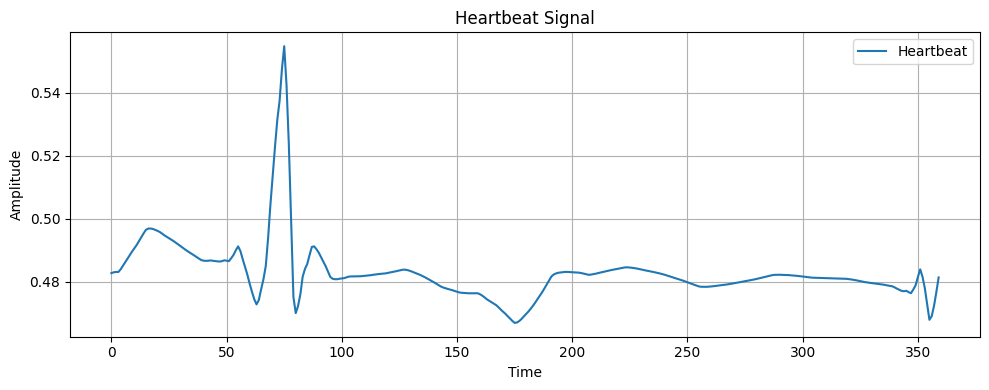

In [14]:
import matplotlib.pyplot as plt
import numpy as np

heartbeat_values = df_fusionné.iloc[1,1:]

time_axis = np.arange(0, 360)

# Plotting the heartbeat
plt.figure(figsize=(10, 4))
plt.plot(time_axis, heartbeat_values, label='Heartbeat')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Heartbeat Signal')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

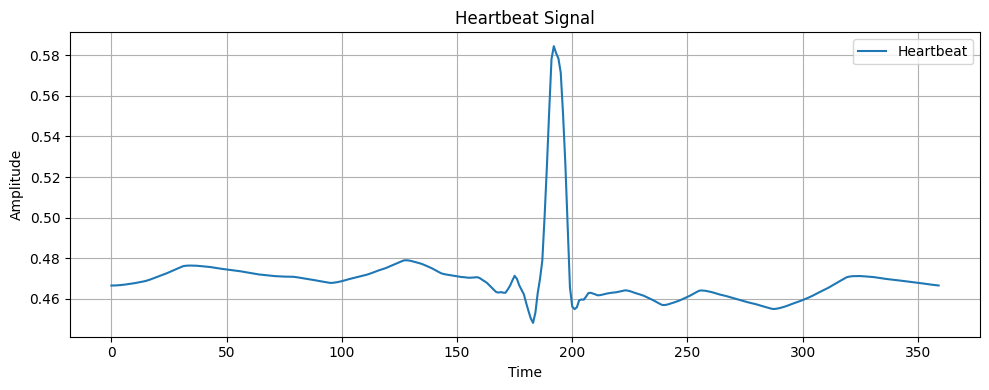

In [13]:
import matplotlib.pyplot as plt
import numpy as np

heartbeat_values = df_fusionné.iloc[2,1:]
heartbeat_values
# Creating a time axis for the 3600 points, assuming each point represents a unit of time
time_axis = np.arange(0, 360)

# Plotting the heartbeat
plt.figure(figsize=(10, 4))
plt.plot(time_axis, heartbeat_values, label='Heartbeat')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Heartbeat Signal')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()